In [1]:
import os
import subprocess
def check_mig_with_smi():
    try:
        output = subprocess.check_output(["nvidia-smi", "-L"], text=True)
        return "MIG" in output
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False

if check_mig_with_smi():
    print("Running on a GPU MIG instance")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print("Not running on a GPU MIG instance")

Not running on a GPU MIG instance


In [2]:
import platform
print(f"Platform: {platform.system()} {platform.release()}")

Platform: Windows 10


In [13]:
# read a yaml file
import yaml
with open('../conf/data/spike256-preprocPDEGym.yaml', 'r') as file:
    config = yaml.safe_load(file)
# print the config
print("Configuration loaded:")
print(config)
#make dot notation for the config
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)
config = Config(config)
# print the config
print("Configuration:")
print(config.resample_shape)
if hasattr(config, 'resample_mode'):
    print("Resample mode:", config.resample_mode)
if hasattr(config, 'preproc_only'):
    print("Preprocessing only mode:", config.preproc_only)
if hasattr(config, 'blablabla'):
    print("Blablabla:", config.blablabla)
else:
    raise ValueError("Configuration does not contain 'blablabla' key")

Configuration loaded:
{'resample_shape': 256, 'resample_mode': 'fourier', 'preproc_only': True, 'datasets': [{'name': 'pdegym-sines-256', 'path': 'PDEGym-Sines', 'ppclass': 'PDEGymPreProcDiv', 'file_ext': 'nc', 'timesample': 1}, {'name': 'pdegym-sl-256', 'path': 'PDEGym-SL', 'ppclass': 'PDEGymPreProcDiv', 'file_ext': 'nc', 'timesample': 1}, {'name': 'pdegym-svs-256', 'path': 'PDEGym-SVS', 'ppclass': 'PDEGymPreProcDiv', 'file_ext': 'nc', 'timesample': 1}, {'name': 'pdegym-pwc-256', 'path': 'PDEGym-PwC', 'ppclass': 'PDEGymPreProcDiv', 'file_ext': 'nc', 'timesample': 1}, {'name': 'pdegym-bb-256', 'path': 'PDEGym-BB', 'ppclass': 'PDEGymPreProcDiv', 'file_ext': 'nc', 'timesample': 1}]}
Configuration:
256
Resample mode: fourier
Preprocessing only mode: True


ValueError: Configuration does not contain 'blablabla' key

In [3]:
import torch

from modelComp.FluidGPT_B import FluidGPT_B

# load yaml file
yaml_path = "../conf/model/std-5.yaml"
import yaml


class DotDict(dict):
    def __init__(self, mapping=None):
        super().__init__()
        mapping = mapping or {} 
        for key, value in mapping.items():
            self[key] = DotDict(value) if isinstance(value, dict) else value

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(f"Key '{key}' not in config")

    def __setattr__(self, key, value):
        self[key] = value

def load_yaml_as_dotdict(filepath):
    with open(filepath, "r") as file:
        data = yaml.safe_load(file) or {}  # for if yaml empty lined
    return DotDict(data)

cm = load_yaml_as_dotdict(yaml_path)

In [4]:
model = FluidGPT_B(emb_dim=96,
                    data_dim=[64, cm.temporal_bundling, cm.in_channels, 128, 128],
                    patch_size=(cm.patch_size, cm.patch_size),
                    hiddenout_dim=cm.hiddenout_dim,
                    depth=cm.depth,
                    stage_depths=cm.stage_depths,
                    num_heads=cm.num_heads,
                    window_size=cm.window_size,
                    use_flex_attn=cm.use_flex_attn
                    ).cuda()
model.eval()
# Load the model weights
checkpoint_path = "C:/Users/20183172/Documents/2024-II/prep/epoch=28-step=563673.ckpt"
checkpoint = torch.load(checkpoint_path, map_location="cuda")
state_dict = checkpoint["state_dict"]
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

c:\Users\20183172\AppData\Local\anaconda3\envs\grad311\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [5]:
x = torch.randn(16, 5, 2, 128, 128).cuda()
with torch.no_grad():
    y = model(x)

In [29]:
from dataloaders.DiskDatasetDiv import DiskDatasetDiv
from torch.utils.data import DataLoader

#dataset = DiskDatasetDiv(preproc_path='../datasets/prjs1359/preproc_amira-s6', temporal_bundling=1)
dataset = DiskDatasetDiv(preproc_path='../datasets/preproc_pdegym-test/', temporal_bundling=5, forward_steps=3)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=16, pin_memory=True, persistent_workers=True)
dataset.avgnorm = dataset.avg
dataset.stdnorm = dataset.std

dataset.avgnorm, dataset.stdnorm


c:\Users\20183172\AppData\Local\anaconda3\envs\grad311\Lib\site-packages\torch\utils\data\dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(1.4613733050067645e-11, 0.6042454048701755)

Batch 1: Output shape: torch.Size([8, 5, 2, 128, 128]), Target shape: torch.Size([8, 5, 2, 128, 128])


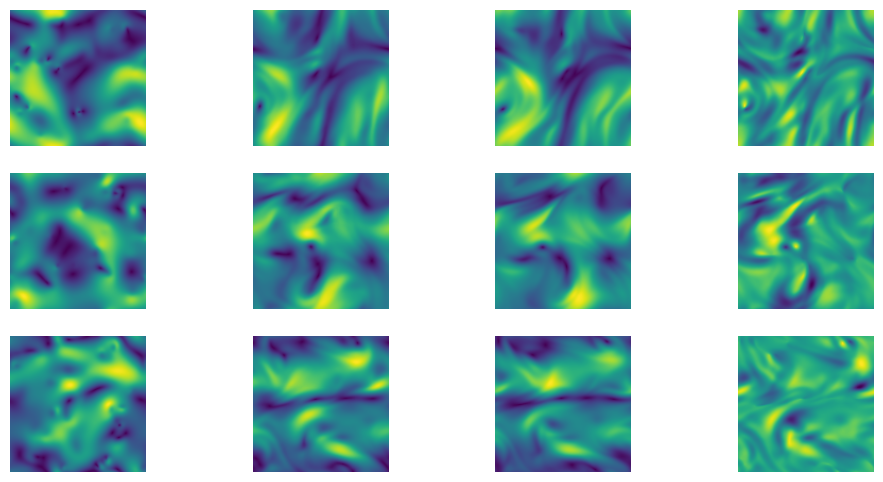

In [ ]:
for i, (x, y) in enumerate(dataloader):
    x = x.cuda()
    y = y.cuda()
    #x = x * dataset.stdnorm + dataset.avgnorm # to test if this was the issue
    #y = y * dataset.stdnorm + dataset.avgnorm
    with torch.no_grad():
        out = x.clone()
        for _ in range(3):
            out = model(out)
        #out = model(x)
    print(f"Batch {i+1}: Output shape: {out.shape}, Target shape: {y.shape}")
    if i == 0:
        break  # Just test the first batch
import matplotlib.pyplot as plt
import numpy as np

x = x * dataset.stdnorm + dataset.avgnorm
y = y * dataset.stdnorm + dataset.avgnorm
out = out * dataset.stdnorm + dataset.avgnorm

def magnitude_vel(x):
    magnitude = torch.sqrt(x[:, :, 0]**2 + x[:, :, 1]**2)
    return magnitude.unsqueeze(2)
x = magnitude_vel(x)
y = magnitude_vel(y)
out = magnitude_vel(out)
# plot the x and y 
fig, ax = plt.subplots(3, 4, figsize=(12, 6))
for i in range(3):
    for j in range(4):
        ax[i, j].axis('off')
        ax[i, 0].imshow(x[i, 0, 0].cpu().numpy())
        ax[i, 1].imshow(out[i, 0, 0].cpu().numpy())
        ax[i, 2].imshow(y[i, 0, 0].cpu().numpy())
        ax[i, 3].imshow(y[i, 0, 0].cpu().numpy() - out[i, 0, 0].cpu().numpy())